## Семинар 2 "Распознавание рукописных цифр"

ФИО: Сербин Георгий Эдуардович

В этом задании мы используем нейронную сеть из предыдущего семинара для распознавания рукописных цифр. Также мы исследуем как влияет выбор нелинейности и предобработка данных на качество классификации.

Чтобы не тратить время на подготовку данных, мы прилагаем готовый код с примером использования для получения обучающей и тестовой выборок. Для запуска скрипта вам понадобится библиотека PyTorch (инструкции по установке можно найти на сайте <a href="http://pytorch.org">pytorch.org</a>)

In [ ]:
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import numpy as np
import sys
from layers import Linear, Sigmoid, NLLLoss, NeuralNetwork # Results from Seminar 1
from IPython.display import clear_output
%matplotlib inline

In [ ]:
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

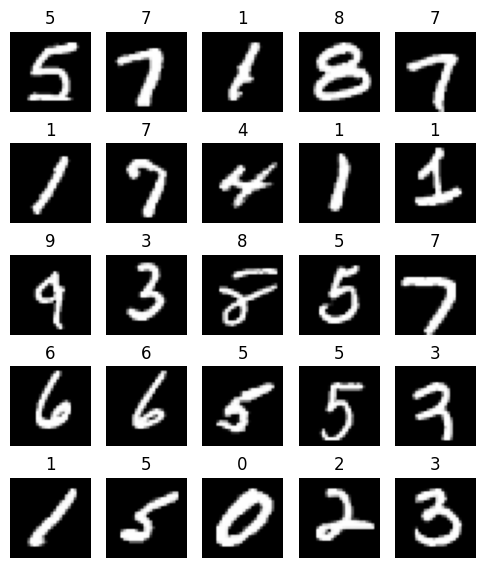

In [ ]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Часть 1: MNIST
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности. Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.01

In [ ]:
def train(network, epochs, learning_rate, plot=True,
          verbose=True, loss=None):
    loss = loss or NLLLoss()
    train_loss_epochs = []
    test_loss_epochs = []
    train_accuracy_epochs = []
    test_accuracy_epochs = []
    try:
        for epoch in range(epochs):
            losses = []
            accuracies = []
            for X, y in train_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                dLdx = loss.backward()
                network.backward(dLdx)
                network.step(learning_rate)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            train_loss_epochs.append(np.mean(losses))
            train_accuracy_epochs.append(np.mean(accuracies))
            losses = []
            accuracies = []
            for X, y in test_loader:
                X = X.view(X.shape[0], -1).numpy()
                y = y.numpy()
                prediction = network.forward(X)
                loss_batch = loss.forward(prediction, y)
                losses.append(loss_batch)
                accuracies.append((np.argmax(prediction, 1)==y).mean())
            test_loss_epochs.append(np.mean(losses))
            test_accuracy_epochs.append(np.mean(accuracies))
            clear_output(True)
            if verbose:
                sys.stdout.write('\rEpoch {0}... (Train/Test) NLL: {1:.3f}/{2:.3f}\tAccuracy: {3:.3f}/{4:.3f}'.format(
                            epoch, train_loss_epochs[-1], test_loss_epochs[-1],
                            train_accuracy_epochs[-1], test_accuracy_epochs[-1]))
            if plot:
                plt.figure(figsize=(12, 5))
                plt.subplot(1, 2, 1)
                plt.plot(train_loss_epochs, label='Train')
                plt.plot(test_loss_epochs, label='Test')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Loss', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.subplot(1, 2, 2)
                plt.plot(train_accuracy_epochs, label='Train accuracy')
                plt.plot(test_accuracy_epochs, label='Test accuracy')
                plt.xlabel('Epochs', fontsize=16)
                plt.ylabel('Accuracy', fontsize=16)
                plt.legend(loc=0, fontsize=16)
                plt.grid('on')
                plt.show()
    except KeyboardInterrupt:
        pass
    return train_loss_epochs, \
           test_loss_epochs, \
           train_accuracy_epochs, \
           test_accuracy_epochs

In [ ]:
network = NeuralNetwork([
    Linear(784, 100), Sigmoid(), # 28 * 28
    Linear(100, 100), Sigmoid(),
    Linear(100, 10)
])
loss = NLLLoss()

Epoch 19... (Train/Test) NLL: 0.308/0.303	Accuracy: 0.919/0.919

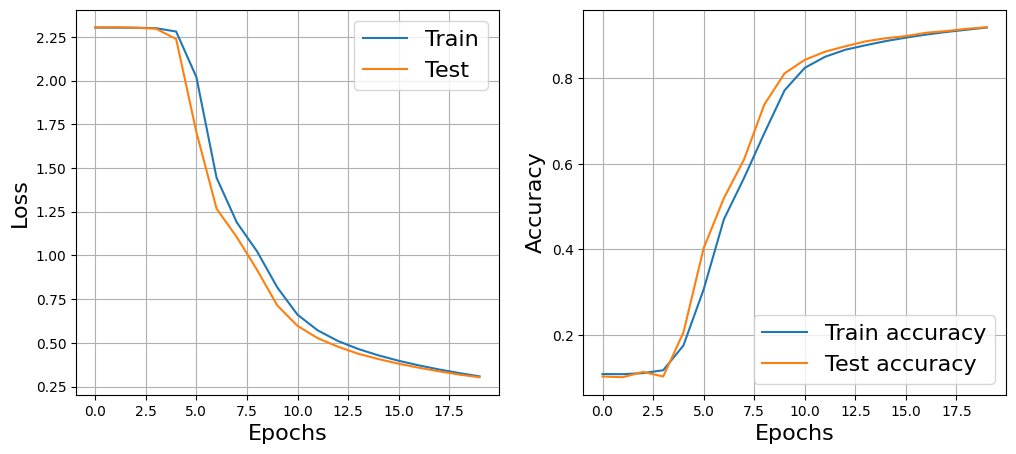

In [ ]:
tr_s, ts_s, tr_ac_s, ts_ac_s = train(network, 20, 0.01)

### Часть 2: Нелинейности

Обучите нейронную сеть с другими нелинейностями: ReLU и ELU. Сравните скорости сходимости и качество классификации с различными функциями активации.

In [ ]:
class ReLU:
    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return np.maximum(X, 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return (self.X > 0) * dLdy

    def step(self, learning_rate):
        pass

In [ ]:
# class ReLU:
#     def __init__(self):
#         pass

#     def forward(self, X):
#         '''
#         Passes objects through this layer.
#         X is np.array of size (N, d)
#         '''
#         self.X = X
#         return np.maximum(X, 0)

#     def backward(self, dLdy):
#         '''
#         1. Compute dLdx.
#         2. Return dLdx
#         '''
#         dydX = (self.X >= 0).astype(float)
#         return dLdy*dydX

#     def step(self, learning_rate):
#         pass

In [ ]:
class ELU:
    '''
    ELU(x) = x, x > 0; a*(e^x - 1), x <= 0
    '''

    def __init__(self, a=1):
        self.a = a

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.X = X
        return X * (X > 0) + self.a * (np.exp(X) - 1) * (X <= 0)

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        X = self.X
        dydX = (X > 0) + self.a * np.exp(X) * (X <= 0)
        return dLdy*dydX

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.035/0.082	Accuracy: 0.991/0.975

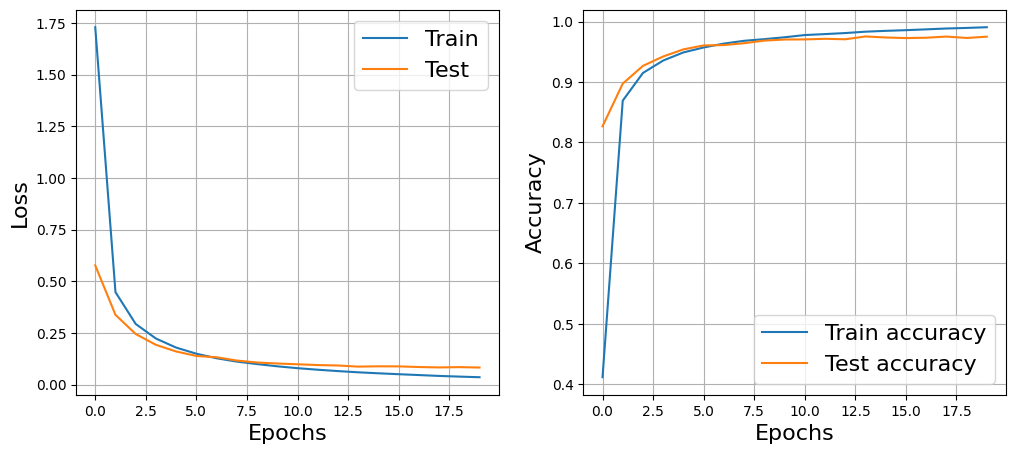

In [ ]:
network = NeuralNetwork([
    Linear(784, 100), ReLU(),
    Linear(100, 100), ReLU(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_r, ts_r, tr_ac_r, ts_ac_r = train(network, 20, 0.01, plot=True, verbose=True)

Epoch 19... (Train/Test) NLL: 0.045/0.086	Accuracy: 0.987/0.974

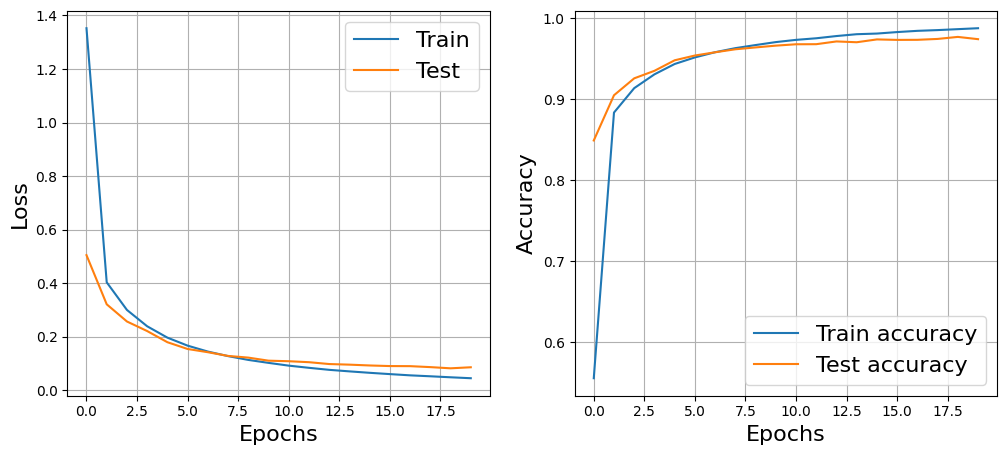

In [ ]:
network = NeuralNetwork([Linear(784, 100), ELU(),
               Linear(100, 100), ELU(),
               Linear(100, 10)])
loss = NLLLoss()
tr_e, ts_e, tr_ac_e, ts_ac_e = train(network, 20, 0.01, plot=True, verbose=True)

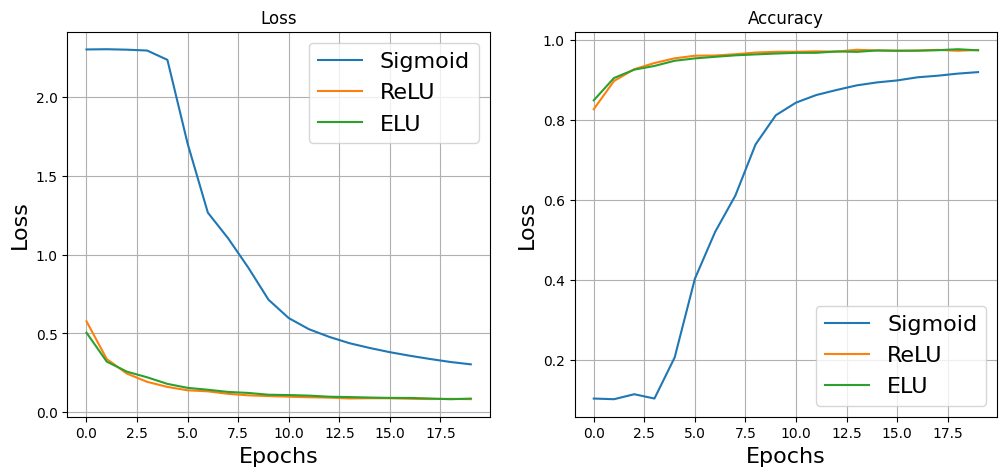

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_s, label='Sigmoid')
plt.plot(ts_r, label='ReLU')
plt.plot(ts_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_s, label='Sigmoid')
plt.plot(ts_ac_r, label='ReLU')
plt.plot(ts_ac_e, label='ELU')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### HW1 (1 балл): Реализовать Tanh

In [ ]:
class Tanh:
    '''
    Tanh(x) = 2 / (1 + e ^ (-2*z)) - 1
    '''

    def __init__(self):
        pass

    def forward(self, X):
        '''
        Passes objects through this layer.
        X is np.array of size (N, d)
        '''
        self.s = 2./(1+np.exp(-2*X)) - 1
        return self.s

    def backward(self, dLdy):
        '''
        1. Compute dLdx.
        2. Return dLdx
        '''
        return dLdy*(1 - self.s ** 2)

    def step(self, learning_rate):
        pass

Epoch 19... (Train/Test) NLL: 0.030/0.074	Accuracy: 0.994/0.977

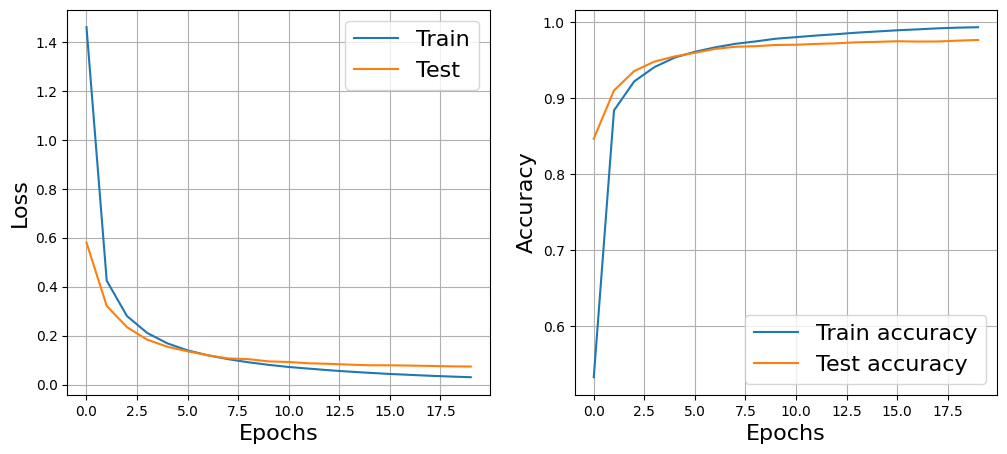

In [ ]:
network = NeuralNetwork([
    Linear(784, 100), Tanh(),
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_t, ts_t, tr_ac_t, ts_ac_t = train(network, 20, 0.01, plot=True, verbose=True)

### Часть 3: Анализ ошибок

In [ ]:
wrong_X = []
correct_y = []
predicted_y = []
logits = []
for X, y in test_loader:
    X = X.view(X.shape[0], -1).numpy()
    y = y.numpy()
    prediction = network.forward(X)
    prediction = np.exp(prediction)
    prediction /= prediction.sum(1, keepdims=True)
    for i in range(len(prediction)):
        if np.argmax(prediction[i]) != y[i]:
            wrong_X.append(X[i])
            correct_y.append(y[i])
            predicted_y.append(np.argmax(prediction[i]))
            logits.append(prediction[i][y[i]])
wrong_X = np.row_stack(wrong_X)
correct_y = np.row_stack(correct_y)[:, 0]
predicted_y = np.row_stack(predicted_y)[:, 0]
logits = np.row_stack(logits)[:, 0]

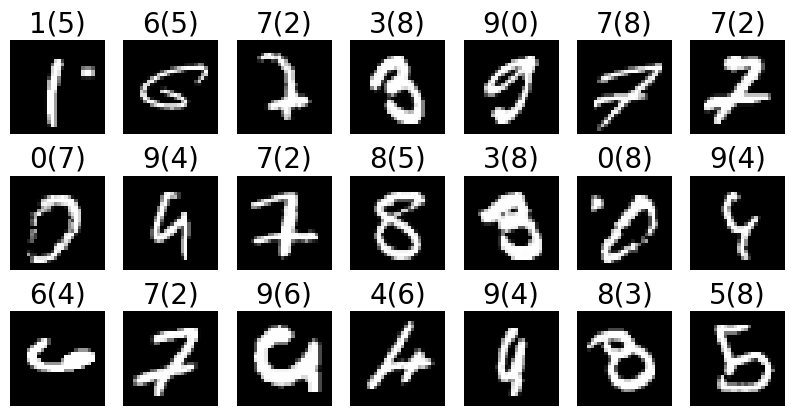

In [ ]:
plt.figure(figsize=(10, 5))
order = np.argsort(logits)
for i in range(21):
    plt.subplot(3, 7, i+1)
    plt.imshow(wrong_X[order[i]].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title('{}({})'.format(correct_y[order[i]], predicted_y[order[i]]), fontsize=20)
    plt.axis('off')

### Часть 4: Аугментация (HW, 2 балла)
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности

In [ ]:
import torch
default_transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
test_dataset = MNIST('.', train=False, transform=default_transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Вращения

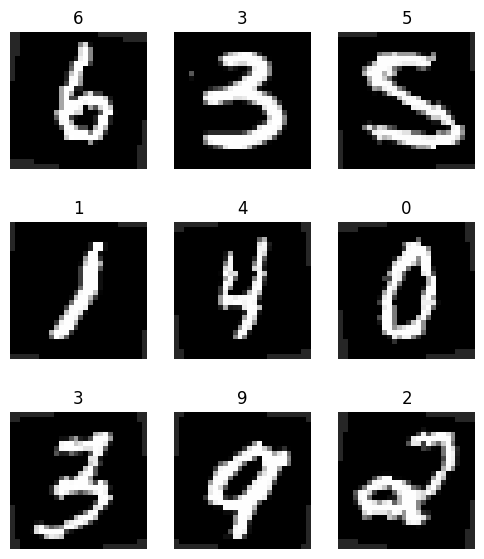

In [ ]:
rotate_transform = transforms.RandomRotation((-15,15))
train_transform = transforms.Compose([
                       default_transform,
                       rotate_transform
                       ])
train_dataset = MNIST('.', train=True, download=True, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

Epoch 19... (Train/Test) NLL: 0.066/0.066	Accuracy: 0.980/0.979

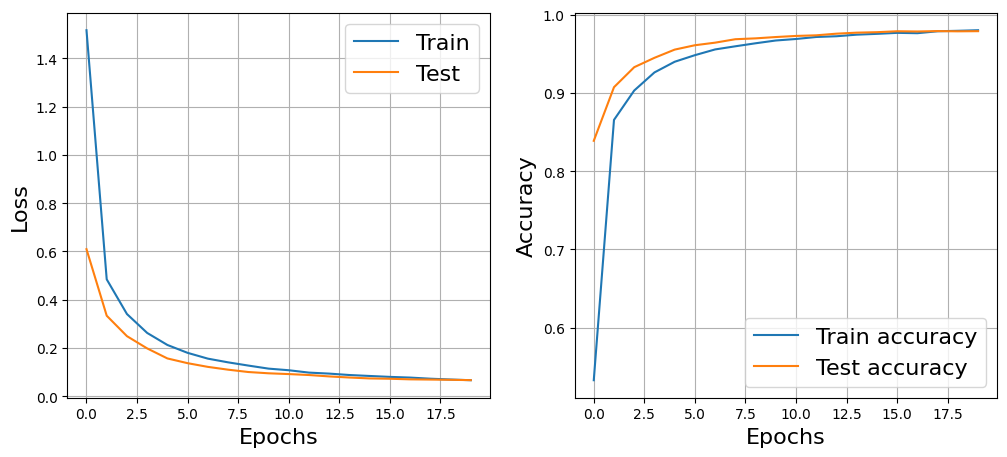

In [ ]:
network = NeuralNetwork([
    Linear(784, 100), Tanh(),
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_rot, ts_rot, tr_ac_rot, ts_ac_rot = train(network, 20, 0.01, plot=True, verbose=True)

Шум

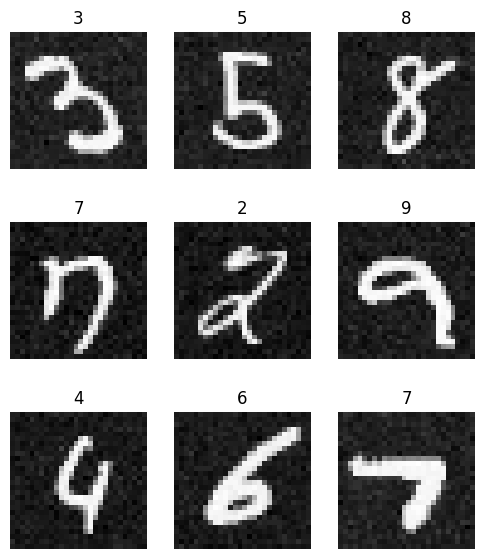

In [ ]:
class GaussianNoise(object):
    def __init__(self, mean=0, std=0.12):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

train_transform = transforms.Compose([
                       default_transform,
                       GaussianNoise()
                       ])
train_dataset = MNIST('.', train=True, download=True, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

Epoch 19... (Train/Test) NLL: 0.031/0.077	Accuracy: 0.993/0.975

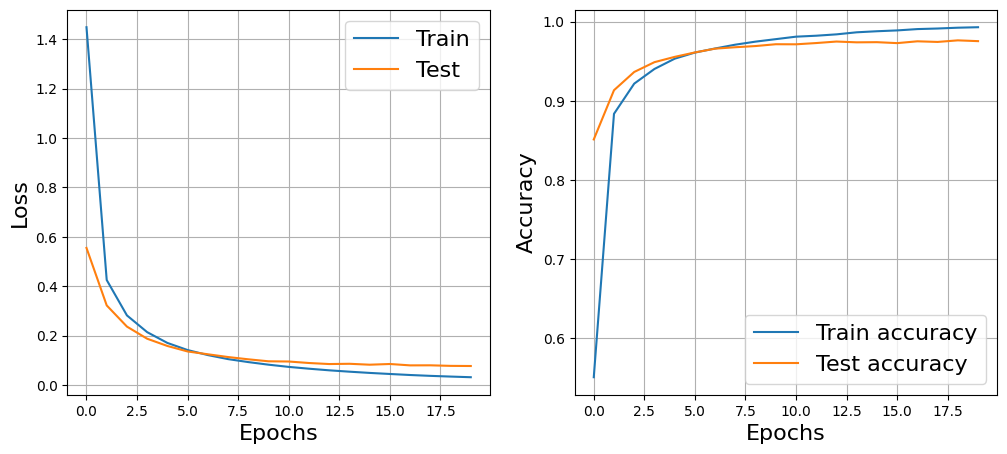

In [ ]:
network = NeuralNetwork([
    Linear(784, 100), Tanh(),
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_noise, ts_noise, tr_ac_noise, ts_ac_noise = train(network, 20, 0.01, plot=True, verbose=True)

Сдвиги

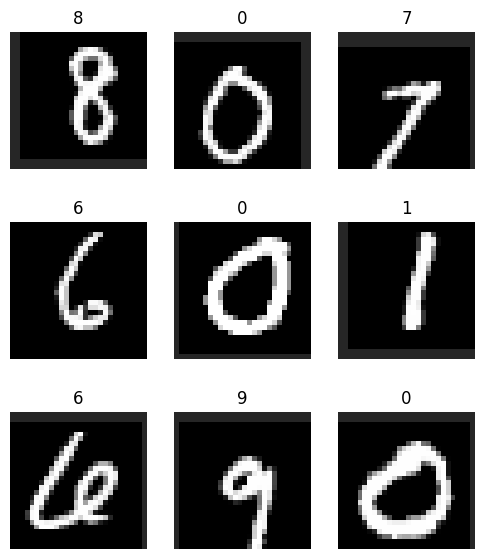

In [ ]:
shift_transform = transforms.RandomAffine(0, (0.1,0.1))
train_transform = transforms.Compose([
                       default_transform,
                       shift_transform
                       ])
train_dataset = MNIST('.', train=True, download=True, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

Epoch 19... (Train/Test) NLL: 0.120/0.075	Accuracy: 0.963/0.976

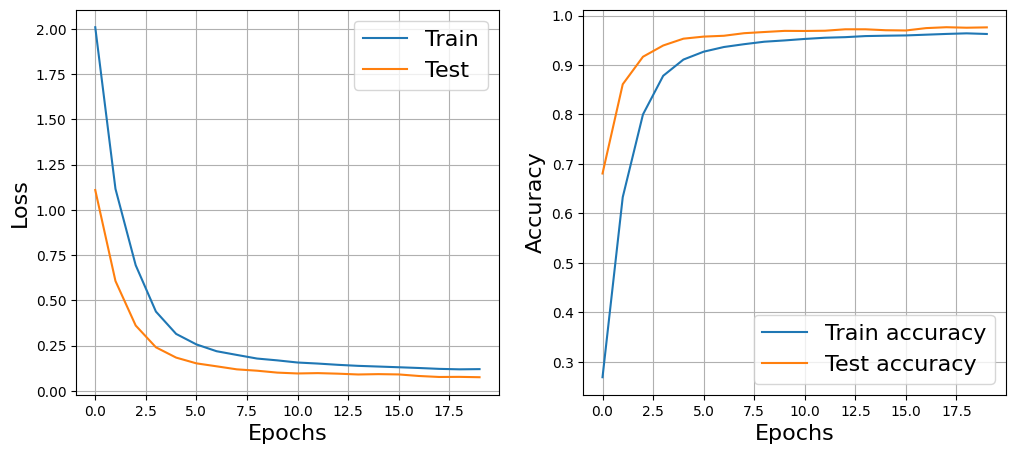

In [ ]:
network = NeuralNetwork([
    Linear(784, 100), Tanh(),
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_shift, ts_shift, tr_ac_shift, ts_ac_shift = train(network, 20, 0.01, plot=True, verbose=True)

Все вместе

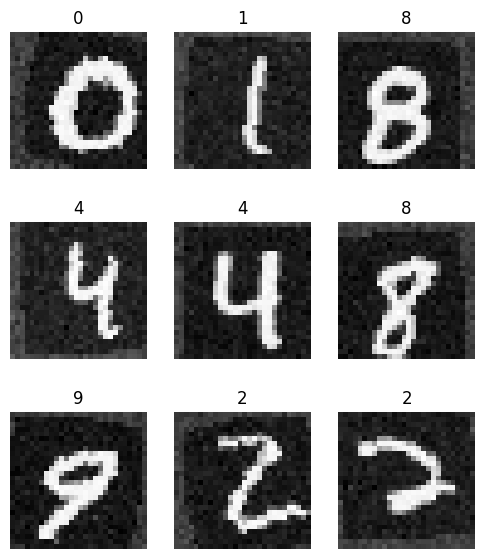

In [ ]:
train_transform = transforms.Compose([
                       default_transform,
                       rotate_transform,
                       shift_transform,
                       GaussianNoise()
                       ])
train_dataset = MNIST('.', train=True, download=True, transform=train_transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

X, y = next(iter(train_loader))
X = X.numpy()
y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

Epoch 19... (Train/Test) NLL: 0.157/0.090	Accuracy: 0.950/0.970

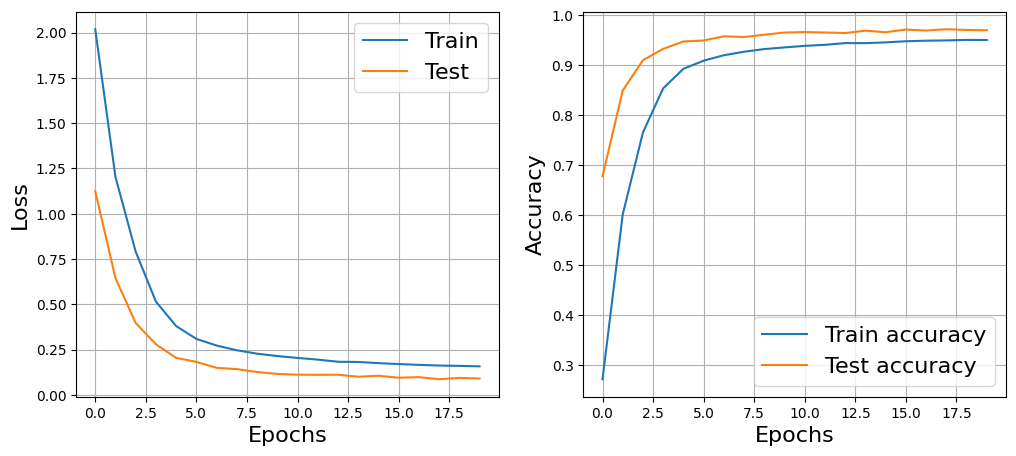

In [ ]:
network = NeuralNetwork([
    Linear(784, 100), Tanh(),
    Linear(100, 100), Tanh(),
    Linear(100, 10)
])
loss = NLLLoss()
tr_total, ts_total, tr_ac_total, ts_ac_total = train(network, 20, 0.01, plot=True, verbose=True)

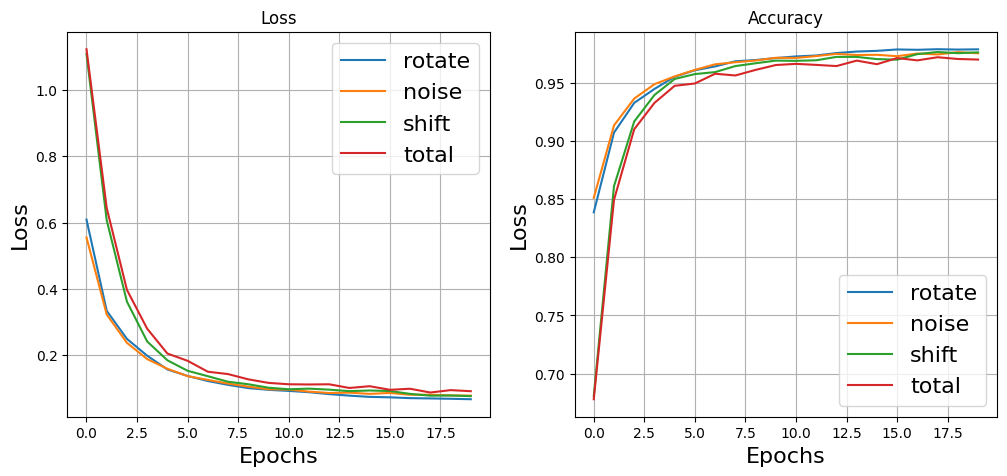

In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Loss')
plt.plot(ts_rot, label='rotate')
plt.plot(ts_noise, label='noise')
plt.plot(ts_shift, label='shift')
plt.plot(ts_total, label='total')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.subplot(1, 2, 2)
plt.title('Accuracy')
plt.plot(ts_ac_rot, label='rotate')
plt.plot(ts_ac_noise, label='noise')
plt.plot(ts_ac_shift, label='shift')
plt.plot(ts_ac_total, label='total')
plt.xlabel('Epochs', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(loc=0, fontsize=16)
plt.grid()
plt.show()

### Часть 5: Выводы
Опишите полученные результаты: как влияют выбор нелинейности и предобработка данных на скорость сходимости и итоговое качество?

Выбор нелинейности сильно влияет на скорость сходимости модели. Для сигмоиды наблюдалась медленная сходимость, вероятно, из-за затухания градиента (max $\sigma'(x) = \frac{1}{4}$). Для ReLU, ELU и Tanh сходимость была быстрее, но наблюдался эффект небольшого переобучения: начиная с некоторой итерации, ошибка на test выборке была больше чем на train выборке. Использование предобработки данных, а именно аугментирование train выборки позволило избежать эффекта переобучения, фактически увеличив размер выборки. Из-за этого качество моделей на тесте после 20 эпох оказалось ощутимо выше. Случайные вращения оказались наиболее эффективными для данной задачи, а наименнее эффективным оказался случайный шум